In [16]:
%load_ext autoreload
%autoreload 2

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from src.energies.alp_energy import ALPEnergy

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [38]:
n_particles = 22
n_spatial_dim = 3
dimensionality = n_spatial_dim * n_particles
energy = ALPEnergy(
    data_path="../../data/alanine/",
    pdb_filename="../../data/pdbs/AA_capped.pdb",
    n_particles=n_particles,
    spatial_dim=n_spatial_dim,
    dimensionality=dimensionality,
    temperature=1200,
    device=device,
    device_index="0",
    should_normalize=True,
    data_normalization_factor=1.0,
)

In [46]:
energy.sample_train_set(10000).reshape(-1, n_particles, n_spatial_dim).std((0, 1)).mean()

tensor(0.1640, device='cuda:0')

In [24]:
energy.sample_train_set(10000).std(1).mean()

tensor(0.1970, device='cuda:0')

Plotting Ramachandran 0 out of 1


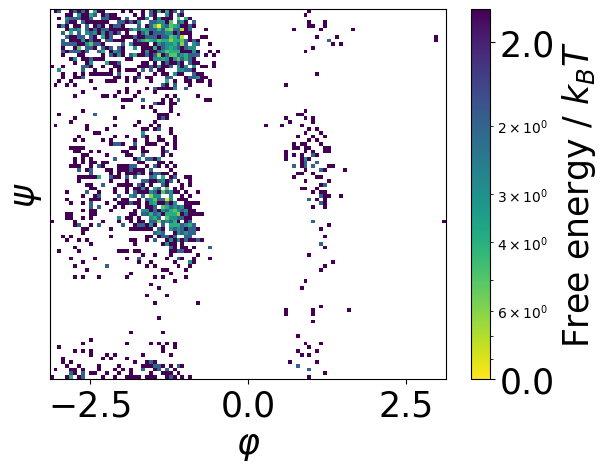

In [12]:
# high_temp_samples = torch.cat(
#     (energy.sample_train_set(10000), energy.sample_test_set(10000), energy.sample_val_set(10000)),
#     dim=0,
# )
high_temp_samples = energy.sample_train_set(2048)
energy.plot_ramachandran(high_temp_samples.detach().cpu());

In [ ]:
plt.hist(-energy(energy.sample_test_set(5000)).cpu(), bins=200, density=True, alpha=0.5);

### Check mixing

In [68]:
n_particles = 22
n_spatial_dim = 3
dimensionality = n_spatial_dim * n_particles


TEMP = 1200
energy = ALPEnergy(
    data_path="../../data/alanine/",
    pdb_filename="../../data/pdbs/A_capped.pdb",
    n_particles=n_particles,
    spatial_dim=n_spatial_dim,
    dimensionality=dimensionality,
    temperature=TEMP,
    device=device,
    device_index="0",
    should_normalize=True,
    data_normalization_factor=0.1641,
)

In [69]:
temp = TEMP

path = f"/network/scratch/a/alexander.tong/energy_temp/data/md/A_capped/A_capped_{temp}_100000.npz"

samples = np.load(path)
samples = samples["all_positions"]
print(f"Loaded samples  has shape: {samples.shape}")
# samples = samples[:50000]
samples = samples.reshape(-1, dimensionality)

samples_tensor = torch.from_numpy(samples).float().to(device)
# print(f"Samples at {temp} has shape: {samples.shape}")

Loaded samples  has shape: (100000, 22, 3)


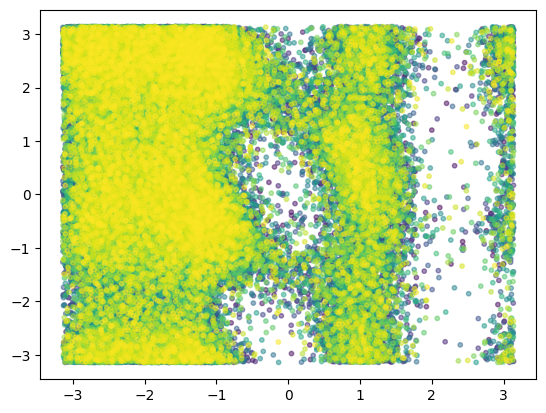

In [70]:
import mdtraj as md
import numpy as np

samples = samples.reshape(-1, energy.n_particles, energy.n_spatial_dim)
traj_samples = md.Trajectory(samples, topology=energy.topology)
phis = md.compute_phi(traj_samples)[1]
psis = md.compute_psi(traj_samples)[1]

plt.scatter(phis, psis, s=10, alpha=0.5, c=torch.arange(phis.shape[0]), cmap="viridis")
# plt.plot(phis, psis, markersize=5, alpha=0.5,)

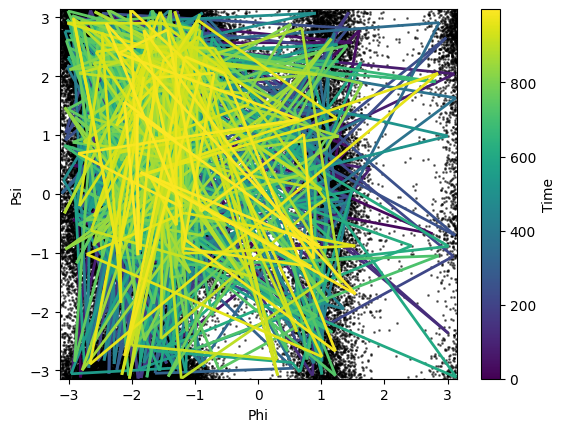

In [71]:
from matplotlib.collections import LineCollection

# Assume phis and psis are 1D arrays of same length

n_times = 1000
points = np.array([phis[:n_times], psis[:n_times]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# The "time" value can be the index of each segment
time = np.arange(n_times - 1)

lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(time.min(), time.max()))
lc.set_array(time)
lc.set_linewidth(2)

fig, ax = plt.subplots()
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax, label='Time')
ax.set_xlim(phis.min(), phis.max())
ax.set_ylim(psis.min(), psis.max())
ax.set_xlabel("Phi")
ax.set_ylabel("Psi")


ax.scatter(phis, psis, s=1, alpha=0.5, c="black")

plt.show()


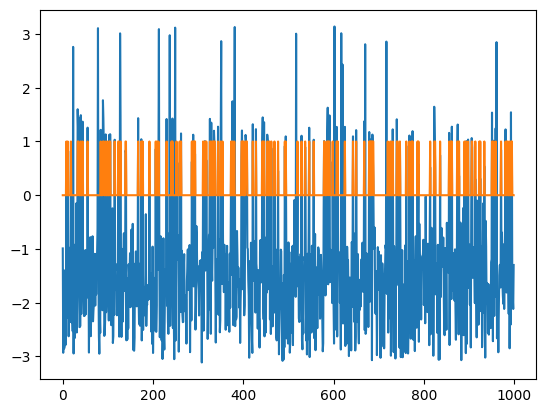

In [73]:
# trace plot
n_times_trace = 1000

bin_phi = (phis > 0) & (phis < 2)
plt.plot(phis[:n_times_trace], label="Phi")
plt.plot(bin_phi[:n_times_trace], label="Bin Phi")

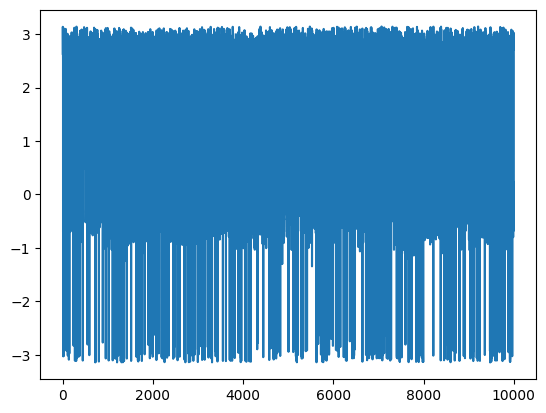

In [61]:
# trace plot
n_times_trace = 10000
plt.plot(psis[:n_times_trace], label="Psi")